## pytorch base
### Load and Visualize the Data

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Visualize a Batch of Training Data

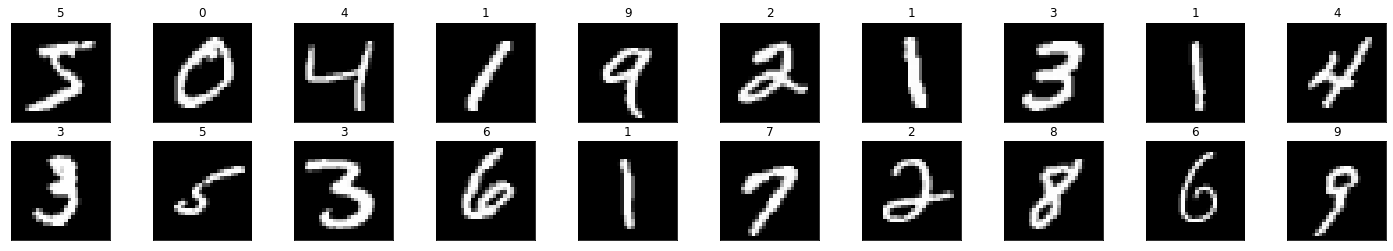

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### Define the Network Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128,10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # image input을 펼쳐준다.
        x = x.view(-1, 28*28)

        # 은닉층을 추가하고 활성화 함수로 relu 사용
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # 은닉층을 추가하고 활성화 함수로 relu 사용
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # 출력층 추가
        x = self.fc3(x)
        return x

# initialize the NN / 모델 확인
model = Net()
model = model.to('cuda')
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### Specify Loss Function and Optimizer

In [ ]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters())

### Train the Network

In [ ]:
# number of epochs to train the model
n_epochs = 20  # suggest training between 10-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        data, target = data.to('cuda') , target.to('cuda')
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.455360
Epoch: 2 	Training Loss: 0.273155
Epoch: 3 	Training Loss: 0.235739
Epoch: 4 	Training Loss: 0.215715
Epoch: 5 	Training Loss: 0.202094
Epoch: 6 	Training Loss: 0.193647
Epoch: 7 	Training Loss: 0.184793
Epoch: 8 	Training Loss: 0.176356
Epoch: 9 	Training Loss: 0.174694
Epoch: 10 	Training Loss: 0.169248
Epoch: 11 	Training Loss: 0.165170
Epoch: 12 	Training Loss: 0.159373
Epoch: 13 	Training Loss: 0.156535
Epoch: 14 	Training Loss: 0.155187
Epoch: 15 	Training Loss: 0.153171
Epoch: 16 	Training Loss: 0.147944
Epoch: 17 	Training Loss: 0.151184
Epoch: 18 	Training Loss: 0.147198
Epoch: 19 	Training Loss: 0.143237
Epoch: 20 	Training Loss: 0.146326


### Test The Trained Network

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    if len(target.data) != batch_size:
          break
    data, target = data.to('cuda') , target.to('cuda')
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.093373

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 96% (979/1010)
Test Accuracy of     4: 98% (968/982)
Test Accuracy of     5: 97% (871/892)
Test Accuracy of     6: 97% (930/958)
Test Accuracy of     7: 96% (995/1028)
Test Accuracy of     8: 95% (931/974)
Test Accuracy of     9: 95% (968/1009)

Test Accuracy (Overall): 97% (9745/10000)


## Tensorflow base
### Prepare the Data
### 데이터를 train_loader에서 받아와 numpy로 바꿔주기로 했다.

In [ ]:
from tensorflow import keras
import tensorflow as tf
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
#batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)
for data, target in train_loader:
  train_input = data
  train_target = target

for data, target in test_loader:
  test_input = data
  test_target = target
  
train_input = train_input.numpy()
train_target = train_target.numpy()
test_input = test_input.numpy()
test_target = test_target.numpy()

train_input.shape # (60000, 1, 28, 28)
train_target.shape # (60000,)

train_input = train_input.squeeze(axis=1)
test_input = test_input.squeeze(axis=1)

### Preprocessing

In [ ]:
train_scaled = train_input / 255.0
test_scaled = test_input / 255.0

from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

### Making Model

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28,28)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trai

### Training

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=50, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])
model = keras.models.load_model('best-model.h5')

print(early_stopping_cb.stopped_epoch)

0


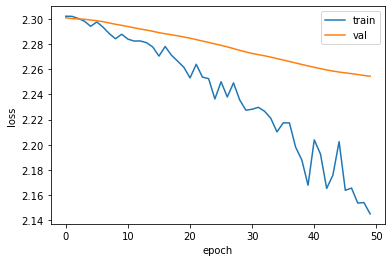

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### Test

In [ ]:
test_labels = np.argmax(model.predict(test_scaled), axis=-1)
print(np.mean(test_labels == test_target))

0.25
